## **Exploratory Data Analysis**

In [12]:
import torch
import torch.nn.functional as F
from torchvision.io import read_image
import torch.nn.functional as F

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

from tqdm import tqdm

%matplotlib inline

raw_data_dir = Path("../data/raw/")
inter_data_dir = Path("../data/interm/")
train_dir = raw_data_dir / "train"
test_dir = raw_data_dir / "test"
valid_dir = raw_data_dir / "valid"

classes = pd.read_csv(raw_data_dir / "class_dict.csv")
metadata = pd.read_csv(raw_data_dir / "metadata.csv")
transformed_masks_path = inter_data_dir / "train_masks"
image_ids = metadata[metadata["split"] == "train"]["image_id"].values


# mapping from class indices to RGB
class_to_rgb = {}
for idx, row in classes.iterrows():
    class_to_rgb[row[0]] = row[1:].to_list()
class_colors = [tuple(x) for x in class_to_rgb.values()]
num_classes = len(class_colors)

### Some EDA

There data cosists of 3 dirs(train, test, valid) along with a .csv with the classes and another with the annotations.

In [2]:
# number of files
print(f"Number of files in the train dir: {len(os.listdir(train_dir))}")
print(f"Number of files in the test dir : {len(os.listdir(test_dir))}")
print(f"Number of files in the valid dir: {len(os.listdir(valid_dir))}")

Number of files in the train dir: 1606
Number of files in the test dir : 172
Number of files in the valid dir: 171


The satellite images are in `.jpg` format while the mask in `.png`

In [3]:
# there are png and jpg files
display(os.listdir(train_dir)[:10])

['350033_mask.png',
 '443271_sat.jpg',
 '442329_mask.png',
 '627806_mask.png',
 '956410_sat.jpg',
 '148381_sat.jpg',
 '495406_mask.png',
 '652183_sat.jpg',
 '759855_mask.png',
 '162310_sat.jpg']

The test and valid directories don't contain masks:

In [4]:
def list_ext(dir_path, ext):
    n_files = len([name for name in os.listdir(dir_path) if name.endswith(ext)])
    print(f"Files with '{ext}' extension in {dir_path} dir: {n_files}")


list_ext(train_dir, "jpg")
list_ext(train_dir, "png")
list_ext(test_dir, "jpg")
list_ext(test_dir, "png")
list_ext(valid_dir, "jpg")
list_ext(valid_dir, "png")

Files with 'jpg' extension in ../data/raw/train dir: 803
Files with 'png' extension in ../data/raw/train dir: 803
Files with 'jpg' extension in ../data/raw/test dir: 172
Files with 'png' extension in ../data/raw/test dir: 0
Files with 'jpg' extension in ../data/raw/valid dir: 171
Files with 'png' extension in ../data/raw/valid dir: 0


The `annotations` file contains the annotations of the images, including the sattelite and mask paths and the splits

In [5]:
metadata

,image_id,split,sat_image_path,mask_path
0,100694,train,train/100694_sat.jpg,train/100694_mask.png
1,102122,train,train/102122_sat.jpg,train/102122_mask.png
2,10233,train,train/10233_sat.jpg,train/10233_mask.png
3,103665,train,train/103665_sat.jpg,train/103665_mask.png
4,103730,train,train/103730_sat.jpg,train/103730_mask.png
...,...,...,...,...
1141,979233,test,test/979233_sat.jpg,NaN
1142,983689,test,test/983689_sat.jpg,NaN
1143,988205,test,test/988205_sat.jpg,NaN
1144,989953,test,test/989953_sat.jpg,NaN


The `classes` file contains the mappings between the land types and the pixel colors

In [6]:
classes

,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255
5,barren_land,255,255,255
6,unknown,0,0,0


In [7]:
# map classes to RGB values
class_to_rgb = {}
for idx, row in classes.iterrows():
    class_to_rgb[row[0]] = row[1:].to_list()
class_colors = [tuple(x) for x in class_to_rgb.values()]
class_colors

[(0, 255, 255),
 (255, 255, 0),
 (255, 0, 255),
 (0, 255, 0),
 (0, 0, 255),
 (255, 255, 255),
 (0, 0, 0)]

The colors of each class are:

```
{'urban_land': 'cyan',
 'agriculture_land': 'yellow',
 'rangeland': 'magenta',
 'forest_land': 'lime',
 'water': 'blue',
 'barren_land': 'white',
 'unknown': 'black'}
```

In [8]:
# dimmensions of the images
sat_img = read_image(str(train_dir / f"{image_ids[0]}_sat.jpg"))
mask = read_image(str(train_dir / f"{image_ids[0]}_mask.png"))
print(f"satellite image dimensions: {sat_img.shape}")
print(f"mask image dimensions: {mask.shape}")

satellite image dimensions: torch.Size([3, 2448, 2448])
mask image dimensions: torch.Size([3, 2448, 2448])


The pixels of the segmentation mask are represented in RGB colors, this is not ideal so we will transform it into values between 0 and 7 (number of classes). This functions will be saved in the utils script.

In [9]:
def rgb_to_label(mask, class_colors):
    """
    Transforms a mask image from RGB format to label encoding.
        Parameters:
            mask: Torch tensor of shape (3, H, W)
            class_colors: list of tuples of the RGB values for each class
        Returns:
            Torch tensor of shape (H, W) of label enconded classes
    """
    h, w = mask.shape[1:]  # shape expected to be (C, H, W)
    semantic_map = torch.zeros((h, w), dtype=torch.uint8)
    for idx, color in enumerate(class_colors):
        color = torch.tensor(color).view(3, 1, 1)  # rgb value
        class_map = torch.all(torch.eq(mask, color), 0)
        semantic_map[class_map] = idx
    return semantic_map


def label_to_onehot(mask, num_classes):
    """
    Transforms a label encoded tensor to one hot encoding.
        Parameters:
            mask: Torch tensor of shape (H, W)
            num_classes: Total number of classes:
        Returns:
            Torch tensor of shape (num_classes, H, W).
    """
    dims_p = (2, 0, 1) if mask.ndim == 2 else (0, 3, 1, 2)
    return torch.permute(
        F.one_hot(mask.type(torch.long), num_classes=num_classes).type(torch.bool),
        dims_p,
    )

In [10]:
# unique values from the images
unique_values = set()
for image_id in tqdm(image_ids):
    mask = read_image(str(train_dir / f"{image_id}_mask.png"))
    unique_values.update(mask.unique().tolist())
unique_values

100%|██████████| 803/803 [05:14<00:00,  2.55it/s]


{0, 255}

In [16]:
# let's try to count the number of pixels of each class
counts = torch.zeros((7,))
for image_id in tqdm(image_ids):
    mask = read_image(str(transformed_masks_path / f"{image_id}_mask.png"))
    counts += torch.bincount(mask.view(-1), minlength=7)

100%|██████████| 803/803 [00:27<00:00, 29.60it/s]


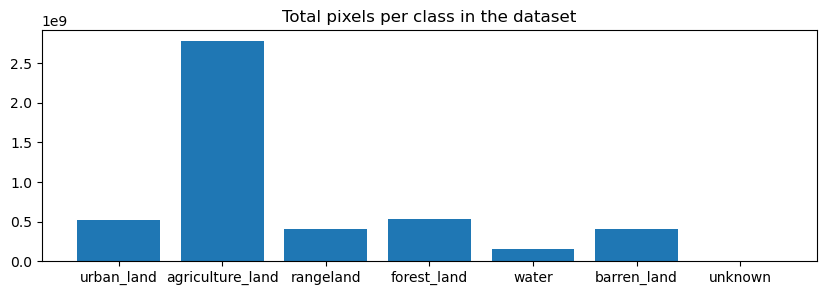

In [17]:
plt.figure(figsize=(10, 3))
plt.bar(class_to_rgb.keys(), counts)
plt.title("Total pixels per class in the dataset")
plt.show()

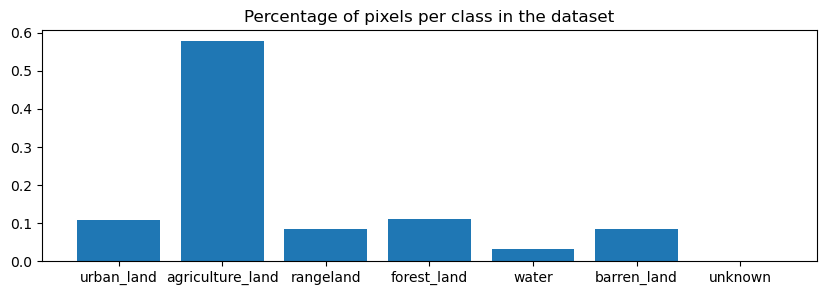

In [18]:
plt.figure(figsize=(10, 3))
plt.bar(class_to_rgb.keys(), counts / counts.sum() * 100)
plt.title("Percentage of pixels per class in the dataset")
plt.show()